
# Deep Learning: Classificando Imagens Astronômicas

<!---
### January 6, 2020


[astroML workshop at the 235th Meeting of the American Astronomical Society](http://www.astroml.org/workshops/AAS235.html)
--->
[Andrew Connolly, Universidade de Washington](http://faculty.washington.edu/ajc26/)

Obrigado a Hayden Smotherman, Universidade de Washington, pelas redes de exemplo.

Neste notebook, trabalhamos com um exemplo simples para uma rede neural usando o TensorFlow e a interface Keras. Inicialmente, começaremos com uma rede básica com duas camadas ocultas e, em seguida, expandiremos isso para uma rede neural convolucional com camadas de queda e normalização em lote.


Deep learning, uma extensão das redes neurais que foram
popularizadas na década de 1990. Os conceitos são inspirados
pela estrutura e função do cérebro. Um neurônio no cérebro é um
unidade computacional central que recebe uma série de entradas de
extensões do neurônio chamadas dendritos, opera nessas entradas,
e gera uma saída que é transmitida ao longo de um axônio para um ou
mais neurônios. No contexto de uma rede neural, um neurônio, $j$, recebe um conjunto de entradas,
$x_i$, aplica uma função, normalmente não linear, a essas entradas e
gera um valor de saída. As redes são então criadas conectando-se
vários neurônios ou camadas de neurônios entre si.

![Neural Network Diagram](figures/fig_neural_network-1.png)

Se considerarmos a rede simplificada,
entradas são passadas para os neurônios no
rede. Cada entrada é ponderada por um valor, $w_{ij}$ e a soma de
Essas entradas ponderadas são operadas por uma resposta ou ativação
função $f(\theta)$, que transforma o
sinal de entrada para que varie entre 0 e 1 através do
aplicação de uma resposta não linear. A saída de qualquer neurônio é
então dado por,

$$
a_j =  f  \left( \sum_i w_{ij} x_i + b_j \right)
$$

onde $b_j$ é um termo de viés que determina o nível de entrada no qual o
neurônio torna-se ativado.

Referimo-nos aos neurônios entre as camadas de entrada e saída como
as camadas ocultas. Se os neurônios de uma camada se conectarem a todos
neurônios em uma camada subsequente, chamamos isso de camada totalmente conectada.
Quando as saídas dos neurônios se conectam apenas às camadas subsequentes
(ou seja, o gráfico é acíclico), nos referimos a isso como um feed-forward
rede - este é o tipo mais comum
de estrutura para uma rede neural usada na classificação.

A camada final na rede é a camada de saída. Tal como acontece com a camada oculta, uma função de ativação, $g(theta)$, na camada de saída atua
na soma ponderada de suas entradas. Nesta figura, temos um único
nó de saída, mas pode haver várias saídas. Para nossa rede de exemplo, a
saída do neurônio final, $y_k$, seria dada por

$$
y_k = g \left( \sum_j   w_{jk} a_j  + b_k \right)  = g\left( \sum_j
  w_{jk}  f \left( \sum_i w_{ij} x_i + b_j\right) + b_k\right)
$$

**O treinamento da rede é simplesmente o aprendizado dos pesos e valores de viés**

In [ ]:
# para reduzir os avisos de substituição
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# verificar se temos GPU disponível
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2025-03-13 14:38:48.051404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:38:48.062292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:38:48.088356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741876728.127011    3012 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741876728.137419    3012 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741876728.162922    3012 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5180369153575543333
 xla_global_id: -1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
%matplotlib inline

### Carregando algumas funções de visualização e auxiliares

Essas funções  ```normalize_image```, ```plot_image_array```, ```plot_confusion_matrix```, ```plot_model_history``` serão usadas para visualizar os dados e as saídas das redes neurais em função do tipo e complexidade da rede.

In [ ]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)

    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)

    return image

def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=False,
                     class_true=None, classes=None):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' %
              (np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx,1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plota a matrix de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusão normalizada'
        else:
            title = 'Matriz de confusão, sem normalização'

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... e rotula com as respectivas entradas da lista
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Gire os rótulos de escala e defina seu alinhamento.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #Corrige o "esmagamento do plot"
    plt.ylim([1.5, -.5])

    #Faz um loop sobre as dimensões de dados e cria anotações de texto.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extraia perda e precisão
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

### Carrega as amostras de treinamento e cria conjuntos de dados de teste e validação

Os dados que estamos usando são retirados de uma pesquisa para NEOs por Lori Allen e colaboradores usando DECam no Telescópio Blanco 4m no CTIO. Os dados compreendem uma pilha de imagens tiradas durante um período de 5 noites. Dentro dessas imagens, procuramos fontes de movimento lento (TNOs) ao longo de possíveis trajetórias orbitais. Dadas essas trajetórias, coadicionamos as imagens. Nosso objetivo é determinar se há uma fonte pontual nas imagens co-adicionadas. A amostra de treinamento inclui imagens de TNOs simulados (verdadeiros positivos; stamps_sources.npz) e trajetórias aleatórias onde não há fonte conhecida (falsos positivos; stamps_noise.npz). Os verdadeiros positivos variam de 100 a 3 em relação ao ruído.

In [ ]:
# Faz o doenload direto, na "força bruta" de imagens de origem e ruído para contornar as limitações de tamanho
# Para verificação interna de vírus do Google Drive. O download pode levar algum tempo.

import os
import requests

files = {'sources': (os.path.join('data', 'stamps_noise.npy'), '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ'),
         'noise': (os.path.join('data', 'stamps_sources.npy'), '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc')}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")

        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content)
    print(f"File {name} is downloaded")

sources = np.load(files['sources'][0])
noise = np.load(files['noise'][0])

File data/stamps_noise.npy is downloaded
File data/stamps_sources.npy is downloaded


In [ ]:
# Normalizando as imagens

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

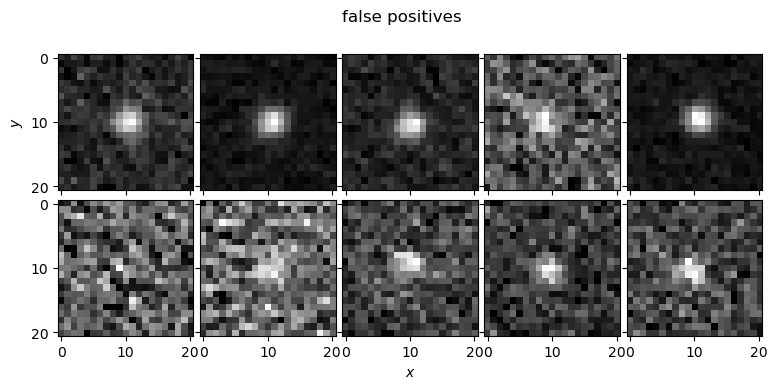

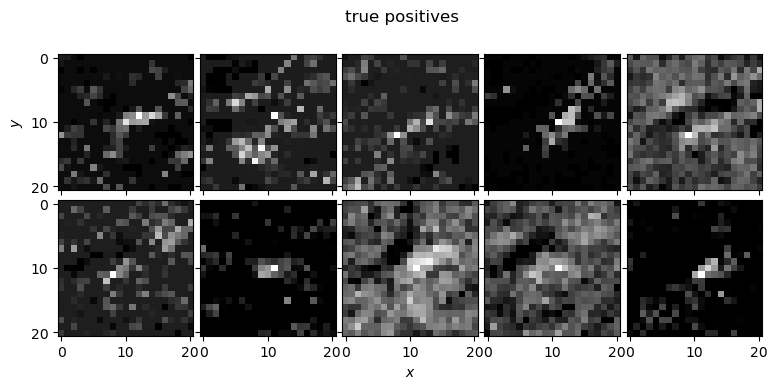

In [ ]:
# plot de amostra de imagens
plot_image_array(no_point_source_stamps, title='falso positivos')
plot_image_array(point_source_stamps, title='verdadeiro positivos')

### Criar uma amostra de treinamento, validação e teste

Usaremos o split_samples do astroML para fazer isso '''split_samples(input_stamps, stamp_class, [0.7,0.1,0.2])''' divide os dados em seleções aleatórias com frações apropriadas de fontes.

In [ ]:
from tensorflow.keras.utils import to_categorical
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1)
    labels = to_categorical(labels)
    return data,labels

# combina os falsos positivos e os verdadeiros positivos
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 para ruído, 1 para uma estrela

# Divide as amostras em conjuntos de dados de treinamento, validação e teste
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class,
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Número de amostras no treinamento ({}); teste ({}); e validacao ({}) data sets'.format(data_train.shape[0],
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (76666); test (21905); and validation (10952) data sets


## Estruturas de rede neural

O desenvolvimento e o lançamento de bibliotecas de aprendizado profundo de código aberto
tornou o uso de redes neurais profundas acessível a uma ampla gama de
Campos. Atualmente, existem dois pacotes comuns: PyTorch (https://pytorch.org) e Tensorflow (https://www.tensorflow.org). Qualquer base de código pode ser utilizada para o
números e problemas neste livro (e geralmente eles têm o mesmo
funcionalidade).

### TensorFlow:

O Tensorflow é a base de código mais estabelecido com uma grande comunidade
e um grande número de tutoriais (https://www.tensorflow.org/tutorials) e cursos online. Sua
funcionalidade é mais desenvolvida do que o PyTorch com ferramentas para visualizar
e inspecionar uma rede (por exemplo, consulte TensorBoard). Por outro lado, a
curva de aprendizado para PyTorch é geralmente considerada mais fácil do que para o Tensorflow, com o PyTorch tendo um objeto mais natural orientado
para pessoas acostumadas a escrever código Python.

### PyTorch:

A principal diferença entre o TensorFlow e o PyTorch é que as
redes (ou gráficos) que o TensorFlow gera são estáticas, enquanto o
as redes para PyTorch são dinâmicas (consulte TensorFlow Fold para gráficos dinâmicos). Isso significa que com o PyTorch pode-se
modificar e ajustar a rede em tempo real (por exemplo, facilitando a
ajustar as alterações na dimensionalidade de entrada ou no número de entradas
nós dentro de uma rede). Esse recurso e o design orientado a objetos de
O PyTorch geralmente resulta em menos linhas de código para obter o mesmo
quando comparado ao Tensorflow.

### Keras:  

Keras é uma API de alto nível escrita sobre o TensorFlow (e seu precursor Theano). Ele é escrito em Python e fornece uma interface simples e intuitiva ao construir redes neurais. Atualmente, ele é lançado como parte do TensorFlow.

**O que você deve escolher?** Ambas as estruturas estão em constante evolução.
A escolha da biblioteca de aprendizado profundo
se resume a qual você acha que melhor se adapta ao seu estilo de
programação e aprendizagem. Para este tutorial, usaremos o Keras, pois ele possui uma implementação intuitiva dos modelos gráficos ou de rede.

### Construindo uma rede:

Vamos começar definindo o que precisamos para a rede. Começaremos com Keras e

- crie um modelo sequencial (isso significa que adicionamos camadas uma a uma, como vemos em nossa figura introdutória)
- adicione uma camada densa (totalmente conectada) com 30 neurônios
- **input_shape** descreve a dimensionalidade do _input data_ a esta primeira camada oculta
- **ativação** descreve a função de ativação para os neurônios (neste caso, usaremos 'relu'; unidade linear retificada)
- adicione uma segunda camada densa (totalmente conectada) com 30 neurônios
- achate a saída da segunda camada em um único vetor para que possamos usar '''categorical_crossentropy''', pois estamos assumindo que nossas classes são "codificação one-hot" (ou seja, [1,0] ou [0,1]
- adicione uma camada de saída usando "softmax" (isso significa que os valores de ativação para cada classe somam 1 para que possam ser tratados como probabilidades) com 2 nós (_para nosso exemplo, poderíamos ter usado um único output_)

### Treinando a rede
Treinar uma rede neural é conceitualmente simples. Dado um conjunto rotulado
de dados e uma função de perda, precisamos otimizar
os pesos e vieses dentro da rede, minimizando a perda. Uma solução para treinar grandes
redes
usa retropropagação para estimar com eficiência o gradiente da perda
função com respeito
aos pesos e vieses.

:## Criando uma rede neural com Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical

def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 images com 1 canal -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))

    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [ ]:
#Saída da estrutura do modelo
simple_model = simple()
simple_model.summary()

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                    │ (None, 21, 21, 30)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 21, 21, 30)     │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13230)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_out (Dense)                  │ (None, 2)              │        26,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_epochs=1
batch_size=1
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)

76666/76666 ━━━━━━━━━━━━━━━━━━━━ 542s 7ms/step - accuracy: 0.6026 - loss: 0.6472 - val_accuracy: 0.4514 - val_loss: 0.6941


### Exercício

**Mini-lote:** A otimização dos pesos usa uma técnica padrão de gradiente descendente. Se a função de perda puder ser expressa em termos de uma soma sobre subconjuntos dos dados de treinamento (por exemplo, como é o caso do
L2) o treinamento pode ser realizado tanto para o conjunto de dados quanto para um
inteiro, para subconjuntos dos dados (aprendizagem em lote) ou para
entradas (aprendizagem on-line ou estocástica). _Batch gradient descent_ examina todos os pontos nos dados e calcula os gradientes médios antes de atualizar os pesos no modelo. _Stochastic gradiente descent_ pega um único ponto e calcula os gradientes e, em seguida, atualiza o modelo (e depois repete). _Mini-batch gradient descent_ pega um subconjunto dos dados de treinamento e calcula os gradientes médios e atualiza o modelo (e depois se repete em todos os minilotes).

In [ ]:
n_epochs=20
batch_size=32
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)

Epoch 1/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - accuracy: 0.8150 - loss: 0.3842 - val_accuracy: 0.9055 - val_loss: 0.2888
Epoch 2/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - accuracy: 0.9018 - loss: 0.2910 - val_accuracy: 0.9057 - val_loss: 0.2784
Epoch 3/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - accuracy: 0.9039 - loss: 0.2897 - val_accuracy: 0.9081 - val_loss: 0.2715
Epoch 4/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - accuracy: 0.9045 - loss: 0.2792 - val_accuracy: 0.9076 - val_loss: 0.2661
Epoch 5/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - accuracy: 0.9069 - loss: 0.2740 - val_accuracy: 0.9081 - val_loss: 0.2620
Epoch 6/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - accuracy: 0.9094 - loss: 0.2664 - val_accuracy: 0.9070 - val_loss: 0.2587
Epoch 7/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 117s 49ms/step - accuracy: 0.9089 - loss: 0.2669 - val_accuracy: 0.9081 - val_loss: 0.2559
Epoch 8/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 117s 49ms/step - accuracy: 

### Performance da rede

In [ ]:
# Use a rede para prever valores de classe
classes = simple_model.predict(data_test)
print (classes)

685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
[[4.95e-01 5.05e-01]
 [1.00e+00 3.80e-10]
 [1.00e+00 1.70e-07]
 ...
 [5.23e-02 9.48e-01]
 [5.74e-03 9.94e-01]
 [2.00e-01 8.00e-01]]


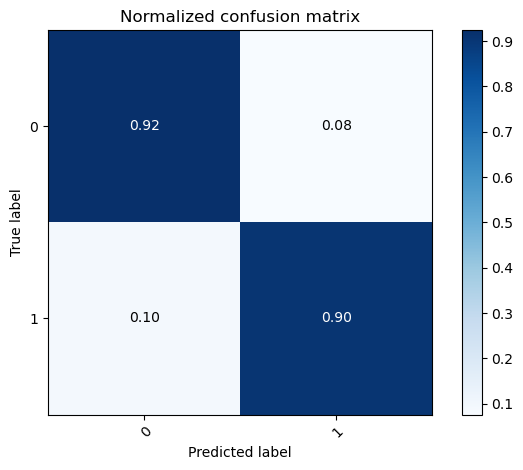

In [ ]:
# plot a matriz de confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Matriz de confusão normalizada')

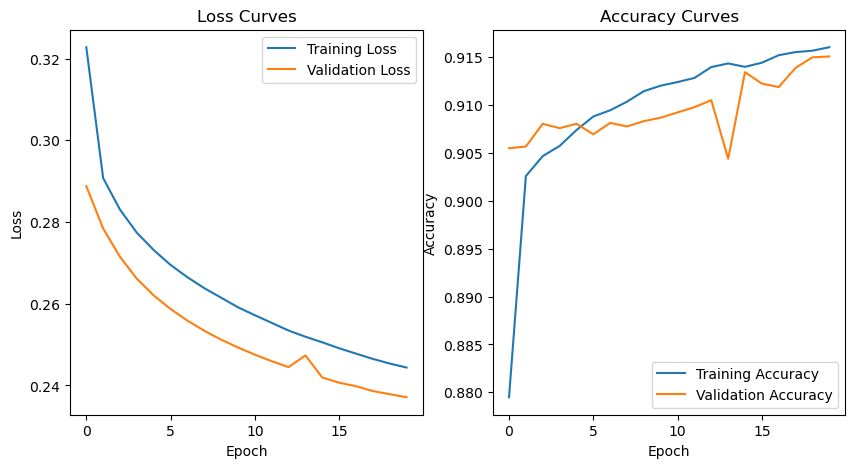

In [ ]:
# plot do histórico de treinamento da rede
plot_model_history(simple_model_history)

### Normalização em lote

Nossa primeira otimização sobre a rede neural básica. A normalização em lote dimensiona as ativações de uma camada (observe que normalizamos os dados de entrada) para ter média zero e variância unitária. Na realidade, os dois parâmetros gama (para o desvio padrão) e beta (para a média) são aprendidos pela rede e as ativações multiplicadas/adicionadas por esses parâmetros. A normalização em lote fornece um grau de regularização e permite taxas de aprendizado mais rápidas, pois as saídas são restritas a 0-1 (ou seja, você não obtém grandes excursões nos pesos das camadas subsequentes em uma rede que precisam ser reotimizadas/treinadas).

A normalização é aplicada a minilotes de dados de treinamento (em vez de usar a amostra de treinamento completa)
- adicionar uma camada de normalização em lote:  ```model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))```



In [ ]:
def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 imagens com 1 canal -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))

    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [ ]:
n_epochs=20
simple_model = simpleBN()
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 105s 346ms/step - accuracy: 0.5492 - loss: 0.6903 - val_accuracy: 0.5456 - val_loss: 0.6889
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 345ms/step - accuracy: 0.5502 - loss: 0.6880 - val_accuracy: 0.5456 - val_loss: 0.6889
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 342ms/step - accuracy: 0.5458 - loss: 0.6888 - val_accuracy: 0.5456 - val_loss: 0.6890
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 336ms/step - accuracy: 0.5498 - loss: 0.6880 - val_accuracy: 0.5456 - val_loss: 0.6888
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 100s 334ms/step - accuracy: 0.5481 - loss: 0.6883 - val_accuracy: 0.5456 - val_loss: 0.6888
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 341ms/step - accuracy: 0.5489 - loss: 0.6881 - val_accuracy: 0.5456 - val_loss: 0.6887
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 335ms/step - accuracy: 0.5461 - loss: 0.6886 - val_accuracy: 0.5456 - val_loss: 0.6887
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 100s 333ms/step - accuracy: 0.5476 -

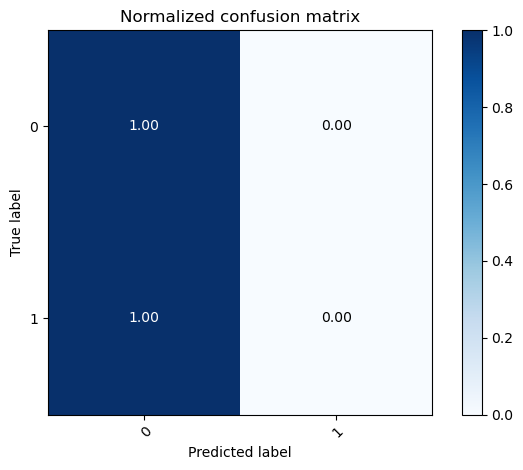

In [ ]:
# Plot da matriz e confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Matriz de comfusão normalizada')

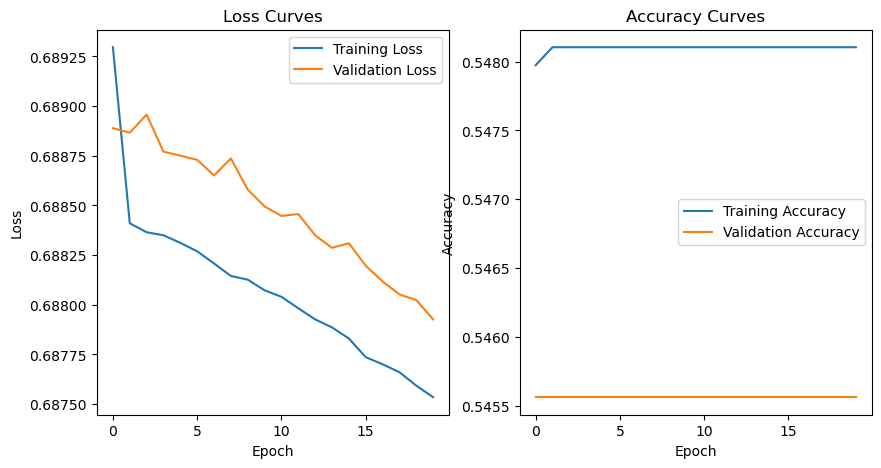

In [ ]:
plot_model_history(simple_model_history)

### Redes Convolucionais

Redes Neurais Convolucionais ou
CNNs são redes projetadas para trabalhar com imagens ou com qualquer
conjunto de dados amostrado. As CNNs reduzem a complexidade da rede ao
exigir que os neurônios respondam apenas a entradas de um subconjunto de um
imagem (o campo receptivo). Isso imita a operação do visual
córtex, onde os neurônios respondem apenas a uma pequena parte do
campo de visão.

Existem quatro componentes principais para uma CNN:
- uma camada convolucional,
- uma _função de ativação não linear_ ,
- uma operação de pooling ou de redução da aferição, e
- uma _camada totalmente conectada para classificação_

Dependente da complexidade da rede ou da estrutura dos dados,
esses componentes podem ocorrer singularmente ou encadeados em várias
seqüências.

![Convolutional Neural Network](figures/fig_cnn_1.png)

**Convolução** em uma CNN refere-se à convolução dos dados de entrada $I(x,y)$ com um kernel $K(x,y)$ que produzirá um mapa de recursos $F(x,y)$
\begin{equation} F(x,y) = K(x,y) * I(x,y) = \sum_{x_0} \sum_{y_0} I(x-x_0, y-y_0) K(x_0, y_0). \end{equation} O kernel responde apenas a pixels dentro de seu campo receptivo (ou seja, o tamanho do kernel), reduzindo a complexidade computacional da rede resultante. Os kernels na convolução são descritos por uma profundidade (o número de kernels, $K$, aplicado à imagem) e um passo (quantos pixels um kernel desloca em cada etapa da convolução; normalmente um). Dada uma imagem $N\times M$, o resultado da etapa de convolução é transformar uma única imagem em um cubo de dados de mapas de recursos com uma dimensão $N \times M \times K$. Uma vez aprendidos, os kernels dentro da camada convolucional podem aparecer como operações fisicamente intuitivas nas imagens, como filtros de detecção de borda.

Tal como acontece com as redes neurais tradicionais, uma função de ativação não linear é aplicada aos pixels individuais nos mapas de recursos resultantes.

O **pooling** na CNN reduz ou subamostra os mapas de recursos. O pooling resume os valores dentro de uma região
de interesse (por exemplo, uma janela de 2x2 pixels). O resumo pode ser a média
valor de pixel, mas mais comumente o valor máximo de pixel é preservado
(Max Pooling) na redução da amostragem. Este agrupamento dos mapas de recursos
reduz o tamanho da rede resultante e torna a rede menos
sensível a pequenas translações ou distorções entre imagens.

A camada final de uma CNN é a camada de classificação que mapeia o
saída da CNN para um conjunto de rótulos. Normalmente, isso é um totalmente
camada conectada onde cada saída
da camada final de agrupamento se conecta a todos os neurônios no
camada de classificação.


### CNNs: Aumentando a complexidade da arquitetura com VGG6

Vamos começar com uma arquitetura de rede simples do Grupo de Geometria Visual de Oxford. VGG6 é uma rede muito simples que tem um bom desempenho em competições tradicionais de classificação de imagens (por exemplo, aquelas que usam os dados ImageNet)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 imagens com 1 canal -> (21, 21, 1) tensors.
    # aplica 16 filtros convolucionais de dimensão 3x3 cada.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### O uso de camadas de dropout

À medida que aumentamos a complexidade da rede, nos deparamos com o problema de sobreajustar os dados (como visto em muitos dos exemplos de astroML). A camada de dropout ```model.add(tf.keras.layers.Dropout(0.5))``` em cada época de treinamento define aleatoriamente um neurônio como 0 com uma probabilidade de 0,5. Há um debate sobre se a camada de dropout deve vir antes ou depois de uma camada de ativação, mas uma regra geral recomendada é que ela deve vir depois da camada de ativação para funções de ativação diferentes de relu.

In [ ]:
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=15
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=2,
                                  validation_data=(data_val, class_val), shuffle=True)
classes = vgg_model.predict(data_test)

Model: "VGG6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 19, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 17, 17, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 6, 6, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 4, 4, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_out (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,458 (99.45 KB)

 Trainable params: 25,394 (99.20 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/15
75/75 - 115s - 2s/step - accuracy: 0.5533 - loss: 0.6877 - val_accuracy: 0.5456 - val_loss: 0.6905
Epoch 2/15
75/75 - 114s - 2s/step - accuracy: 0.5628 - loss: 0.6831 - val_accuracy: 0.5456 - val_loss: 0.6887
Epoch 3/15
75/75 - 113s - 2s/step - accuracy: 0.5721 - loss: 0.6789 - val_accuracy: 0.5456 - val_loss: 0.6872
Epoch 4/15
75/75 - 113s - 2s/step - accuracy: 0.5860 - loss: 0.6741 - val_accuracy: 0.5456 - val_loss: 0.6857
Epoch 5/15
75/75 - 115s - 2s/step - accuracy: 0.5981 - loss: 0.6693 - val_accuracy: 0.5456 - val_loss: 0.6834
Epoch 6/15
75/75 - 114s - 2s/step - accuracy: 0.6107 - loss: 0.6633 - val_accuracy: 0.5456 - val_loss: 0.6818
Epoch 7/15
75/75 - 111s - 1s/step - accuracy: 0.6230 - loss: 0.6565 - val_accuracy: 0.5456 - val_loss: 0.7192
Epoch 8/15
75/75 - 114s - 2s/step - accuracy: 0.6355 - loss: 0.6465 - val_accuracy: 0.5456 - val_loss: 0.7150
Epoch 9/15
75/75 - 110s - 1s/step - accuracy: 0.6437 - loss: 0.6357 - val_accuracy: 0.5457 - val_loss: 0.7288
Epoch 10/1

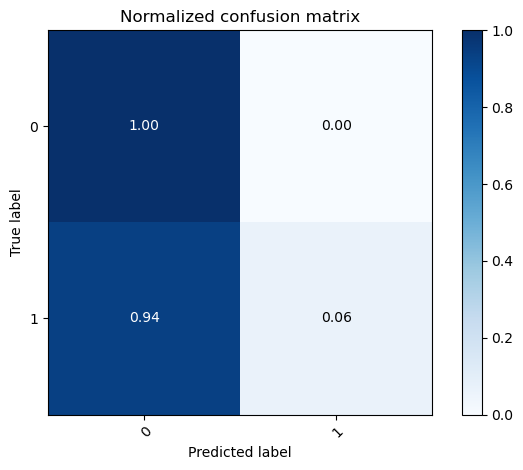

In [ ]:
# plot da matriz de confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='NMatriz de comfusão normalizada')

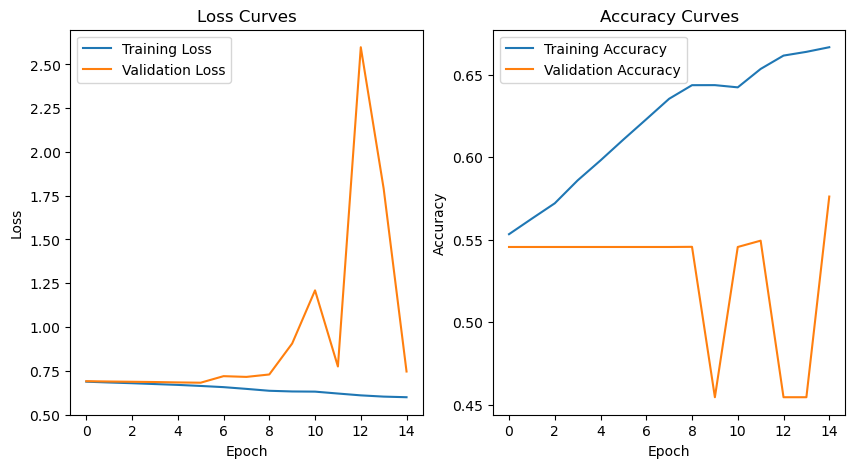

In [ ]:
# plot a história do treinamento
plot_model_history(vgg_model_history)

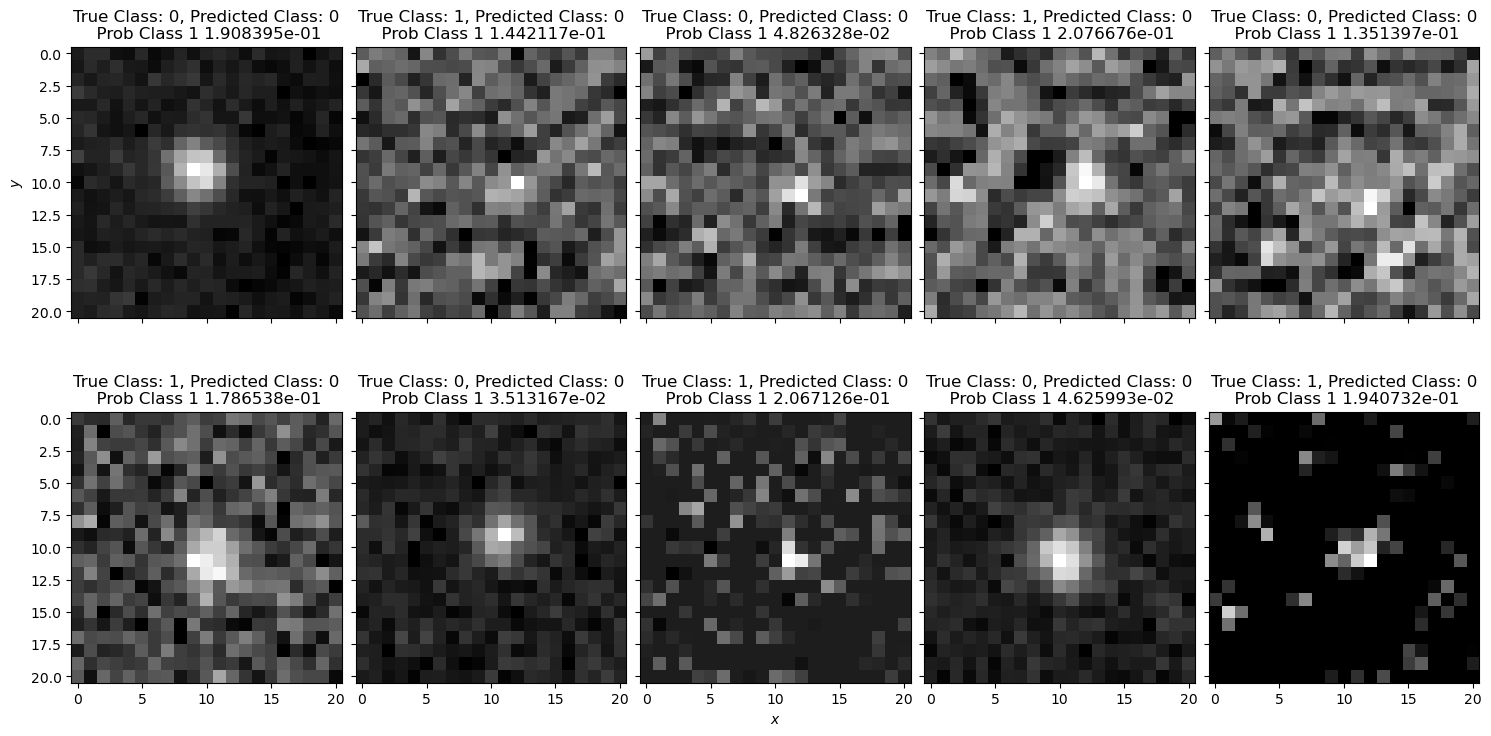

In [ ]:
# plot dos exemplos de classificação
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

### Interpretando redes: quantas camadas e quantos neurônios?

O número de camadas, o número de neurônios em uma camada e
a conectividade dessas camadas é normalmente descrita como a rede
arquitetura.

Abordagens para definir uma
arquitetura de rede se tornam mais tentativa e erro do que aplicar um
conjunto de princípios. Para um ponto de partida, no entanto, existem relativamente
poucos problemas que se beneficiam significativamente de mais de duas camadas e
Recomendamos começar com uma única camada ao treinar um
rede e usando validação cruzada para determinar quando camadas adicionais
resultam em overfit.
Tal como acontece com o número de camadas, o número de neurônios dentro de uma camada
leva a custos computacionais (e exige
conjuntos de treinamento para evitar o overffiting dos dados). Existem muitas
propostas de regras práticas para definir uma arquitetura de rede:
- o número de neurônios deve estar entre o número de nós de entrada e saída
- O número de neurônios deve ser igual ao número de saídas mais 2/3 do número de nós de entrada.
- o número de neurônios na camada oculta deve ser menor que o dobro do tamanho das camadas de entrada.

### Interpretando redes: onde está uma rede olhando

Mapas de ocultação, mapas de saliência, mapas de ativação de classe são todas técnicas para expressar quais pixels contribuem para a classificação. Essas são tentativas de reduzir a natureza de "caixa preta" das redes. O mais simples deles é o mapa de oclusão, onde fazemos parte de uma imagem e calculamos a probabilidade de ela pertencer a uma classe. Se a probabilidade diminuir, a parte ocluída da imagem é considerada importante. Se não houver alteração na probabilidade, os pixels ocluídos não são considerados importantes. Uma implementação simples disso é mostrada aqui.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


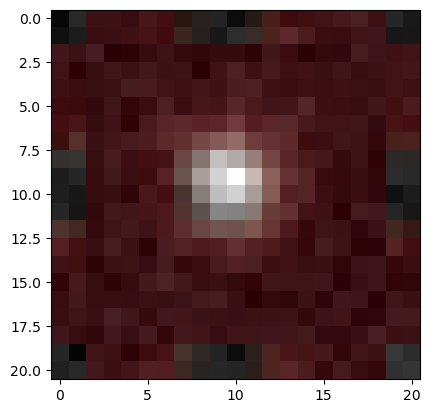

In [ ]:
model = vgg_model
image_number = 11

kernel_size=5
input_stamp = data_test[image_number].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = 1. - model.predict(keras_stamps)
heatmap = probs[:,1].reshape(22-kernel_size,22-kernel_size)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=np.int64(kernel_size/2), mode='minimum')

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(data_test[image_number].reshape(21,21), cmap='gray')
ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap)

### Exercício para o leitor: arquiteturas mais complicadas: resnet50

In [ ]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementação do popular ResNet50 a seguinte arquitetura:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Argumentos:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Retorna:
    model -- a Model() instance in Keras
    """

    # Define a entrada como um tensor com forma input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Estágio 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Estágio 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### Início do código ###

    # Estágio 3 (≈4 linhas)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Estágio 4 (≈6 linhas)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Estágio 5 (≈3 linhas)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### Final do código aqui ###

    # camada de saída
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Cria o modelo
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

2025-03-14 21:39:41.450725: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 21:39:42.361293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 21:39:42.791729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741988383.181069    6337 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741988383.290554    6337 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741988384.167079    6337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                          validation_data=(data_val, class_val), shuffle=True)

2025-03-14 21:39:54.681959: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'data_train' is not defined